In [32]:
import tensorflow as tf
from tensorflow import keras

import numpy as np

print(tf.__version__)

1.13.1


In [ ]:
#1.数据探索
imdb = keras.datasets.imdb
#加载出现频次前20000的字词(numpy版本需为1.16.2)
(train_data, train_labels), (test_data, test_labels) = imdb.load_data(num_words=20000)


In [34]:
#输出训练集数目
print("Training num: {}, labels: {}".format(len(train_data), len(train_labels)))
#查看前两条评论数据
print(train_data[0])    #每个字词经过one-hot编码，转换成一个整型数字
print(len(train_data[0]), len(train_data[1]))

Training num: 25000, labels: 25000
[1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65, 458, 4468, 66, 3941, 4, 173, 36, 256, 5, 25, 100, 43, 838, 112, 50, 670, 2, 9, 35, 480, 284, 5, 150, 4, 172, 112, 167, 2, 336, 385, 39, 4, 172, 4536, 1111, 17, 546, 38, 13, 447, 4, 192, 50, 16, 6, 147, 2025, 19, 14, 22, 4, 1920, 4613, 469, 4, 22, 71, 87, 12, 16, 43, 530, 38, 76, 15, 13, 1247, 4, 22, 17, 515, 17, 12, 16, 626, 18, 19193, 5, 62, 386, 12, 8, 316, 8, 106, 5, 4, 2223, 5244, 16, 480, 66, 3785, 33, 4, 130, 12, 16, 38, 619, 5, 25, 124, 51, 36, 135, 48, 25, 1415, 33, 6, 22, 12, 215, 28, 77, 52, 5, 14, 407, 16, 82, 10311, 8, 4, 107, 117, 5952, 15, 256, 4, 2, 7, 3766, 5, 723, 36, 71, 43, 530, 476, 26, 400, 317, 46, 7, 4, 12118, 1029, 13, 104, 88, 4, 381, 15, 297, 98, 32, 2071, 56, 26, 141, 6, 194, 7486, 18, 4, 226, 22, 21, 134, 476, 26, 480, 5, 144, 30, 5535, 18, 51, 36, 28, 224, 92, 25, 104, 4, 226, 65, 16, 38, 1334, 88, 12, 16, 283, 5, 16, 4472, 113, 103, 32, 15, 16, 5345, 19, 178, 32]
218 189


In [35]:
# A dictionary mapping words to an integer index
word_index = imdb.get_word_index()

# The first indices are reserved
word_index = {k:(v+3) for k,v in word_index.items()}
word_index["<PAD>"] = 0
word_index["<START>"] = 1
word_index["<UNK>"] = 2  # unknown
word_index["<UNUSED>"] = 3

reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

def decode_review(text):
    return ' '.join([reverse_word_index.get(i, '?') for i in text])
#输出第一条影评
print(decode_review(train_data[0]))

<START> this film was just brilliant casting location scenery story direction everyone's really suited the part they played and you could just imagine being there robert <UNK> is an amazing actor and now the same being director <UNK> father came from the same scottish island as myself so i loved the fact there was a real connection with this film the witty remarks throughout the film were great it was just brilliant so much that i bought the film as soon as it was released for retail and would recommend it to everyone to watch and the fly fishing was amazing really cried at the end it was so sad and you know what they say if you cry at a film it must have been good and this definitely was also congratulations to the two little boy's that played the <UNK> of norman and paul they were just brilliant children are often left out of the praising list i think because the stars that play them all grown up are such a big profile for the whole film but these children are amazing and should be p

In [36]:
#2.数据准备

#通过填充数组的方式，使每条评论拥有相同的长度
train_data = keras.preprocessing.sequence.pad_sequences(train_data,value=word_index["<PAD>"],padding='post',maxlen=256)
test_data = keras.preprocessing.sequence.pad_sequences(test_data,value=word_index["<PAD>"],padding='post',maxlen=256)

#查看训练集和测试集的评论长度
print(len(train_data[0]),len(test_data[0]))

#查看第一条影评内容,可以看到该条影评末尾都被填充成0
print(train_data[0])


256 256
[    1    14    22    16    43   530   973  1622  1385    65   458  4468
    66  3941     4   173    36   256     5    25   100    43   838   112
    50   670     2     9    35   480   284     5   150     4   172   112
   167     2   336   385    39     4   172  4536  1111    17   546    38
    13   447     4   192    50    16     6   147  2025    19    14    22
     4  1920  4613   469     4    22    71    87    12    16    43   530
    38    76    15    13  1247     4    22    17   515    17    12    16
   626    18 19193     5    62   386    12     8   316     8   106     5
     4  2223  5244    16   480    66  3785    33     4   130    12    16
    38   619     5    25   124    51    36   135    48    25  1415    33
     6    22    12   215    28    77    52     5    14   407    16    82
 10311     8     4   107   117  5952    15   256     4     2     7  3766
     5   723    36    71    43   530   476    26   400   317    46     7
     4 12118  1029    13   104    88     4 

In [42]:
#3.构建一个简单的分类模型
# input shape is the vocabulary count used for the movie reviews (20,000 words)
vocab_size = 20000

model = keras.Sequential()
#(1)输入层(Embedding),该层会在词汇表中查找每个字词-索引的向量，模型学习之后会生成维度(batch,sequence,embedding)
model.add(keras.layers.Embedding(vocab_size, 16))
#(2)GloablAveragePooling1D层,该层会对序列维度求平均值，为每个样本输出一个长度固定的向量
model.add(keras.layers.GlobalAveragePooling1D())
#(3)Dense层,将上层的输出向量传入到全连接层
model.add(keras.layers.Dense(16, activation=tf.nn.relu))
#(4)输出层.通过sigmoid函数将结果输出到单个输出节点
model.add(keras.layers.Dense(1, activation=tf.nn.sigmoid))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, None, 16)          320000    
_________________________________________________________________
global_average_pooling1d_4 ( (None, 16)                0         
_________________________________________________________________
dense_8 (Dense)              (None, 16)                272       
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 17        
Total params: 320,289
Trainable params: 320,289
Non-trainable params: 0
_________________________________________________________________


In [43]:
#配置模型优化器和损失函数
model.compile(optimizer=tf.train.AdamOptimizer(),
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [44]:
#创建验证集,用来评估模型效果
x_val = train_data[:10000]
partial_x_train = train_data[10000:]

y_val = train_labels[:10000]
partial_y_train = train_labels[10000:]


In [45]:
#4.模型训练
#batch_size=1024,epochs=50
history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=30,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)

Train on 15000 samples, validate on 10000 samples
Epoch 1/30
15000/15000 [==============================] - 2s 153us/sample - loss: 0.6921 - acc: 0.5404 - val_loss: 0.6903 - val_acc: 0.5275
Epoch 2/30
15000/15000 [==============================] - 2s 131us/sample - loss: 0.6867 - acc: 0.5673 - val_loss: 0.6835 - val_acc: 0.6870
Epoch 3/30
15000/15000 [==============================] - 2s 136us/sample - loss: 0.6763 - acc: 0.7571 - val_loss: 0.6711 - val_acc: 0.7508
Epoch 4/30
15000/15000 [==============================] - 2s 133us/sample - loss: 0.6585 - acc: 0.7820 - val_loss: 0.6511 - val_acc: 0.7735
Epoch 5/30
15000/15000 [==============================] - 2s 124us/sample - loss: 0.6312 - acc: 0.8039 - val_loss: 0.6208 - val_acc: 0.7898
Epoch 6/30
15000/15000 [==============================] - 2s 137us/sample - loss: 0.5924 - acc: 0.8204 - val_loss: 0.5838 - val_acc: 0.8042
Epoch 7/30
15000/15000 [==============================] - 2s 132us/sample - loss: 0.5486 - acc: 0.8321 - val_l

In [46]:
#5.评估模型效果
results = model.evaluate(test_data, test_labels)
print(results)


25000/25000 [==============================] - 1s 30us/sample - loss: 0.3017 - acc: 0.8773
[0.3017049396419525, 0.87732]


In [47]:
history_dict = history.history
print(history_dict.keys())

dict_keys(['loss', 'acc', 'val_loss', 'val_acc'])


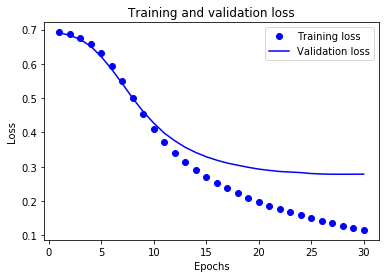

In [48]:
#绘制训练集和验证集损失图表

import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

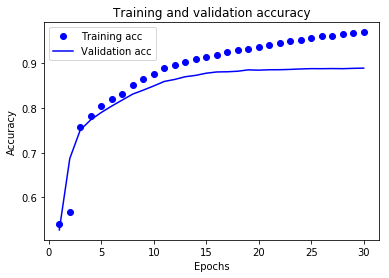

In [49]:
#绘制训练集和验证集准确率图表
plt.clf()   # clear figure
acc_values = history_dict['acc']
val_acc_values = history_dict['val_acc']

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()